In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 2: Model 1

In [ ]:
import json
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, GPT2Tokenizer

class EmotionTriggerDataset(Dataset):
    def __init__(self, data_file, max_length=512):
        with open(data_file, 'r') as f:
            data = json.load(f)

        self.data = data
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.bert_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

        self.max_length = max_length
        self.label_mapping = {'disgust': 0,
                               'anger': 1,
                               'sadness': 2,
                               'surprise': 3,
                               'neutral': 4,
                               'joy': 5,
                               'fear': 6,
                              '<pad>': 7}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # if idx in [513,655]:
        #     idx=512

        speaker = self.data[idx]['speakers']
        utterances = self.data[idx]['utterances']
        emotions = self.data[idx]['emotions']
        final_utterance = [s + '  ' + u + '  '  for s, u,in zip(speaker, utterances)] # X
        final_utterance = final_utterance + [self.bert_tokenizer.pad_token] * (24 - len(final_utterance))


        bert_inputs = self.bert_tokenizer(final_utterance, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='np')
        bert_input_ids = torch.tensor(bert_inputs['input_ids'],dtype=torch.float32)
        emotions = [self.label_mapping[i] for i in emotions]
        emotions += [7] * (24 - len(emotions))
        emotional_label = torch.tensor(emotions, dtype=torch.float32)

        return bert_input_ids, emotional_label

In [ ]:
data_file = '/Data/train_file.json'
dataset = EmotionTriggerDataset(data_file)
input_id ,tg = dataset[200]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [ ]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, GPT2Model, BertTokenizer, GPT2Tokenizer
from tqdm import tqdm

In [ ]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer,TransformerDecoderLayer,TransformerDecoder
from torch.utils.data import dataset
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, d_model: int =768, nhead: int=8, d_hid: int=200,nlayers: int=6, dropout: float = 0.2):
        super(Encoder, self).__init__()
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)


    def forward(self, x):

        x= x.permute(1,0,2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self, d_model: int =768, nhead: int=64, d_hid: int=200,nlayers: int=8, dropout: float = 0.2):
        super(Decoder, self).__init__()
        decoder_layers = TransformerDecoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layers, nlayers)
        self.pos_encoder = PositionalEncoding(d_model, dropout)


    def forward(self,last,memory):
        # print(last.shape)
        x= last.permute(1,0,2)
        x = self.pos_encoder(x)
        x = self.transformer_decoder(x,memory)
        return x




# class EmotionClassifier(nn.Module):
#     def __init__(self, input_size=512, hidden_size=64, output_size=1, num_layers=1):
#         super(EmotionClassifier, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.activation = nn.Softmax(dim=2)

#     def forward(self, x):
#         # Initialize hidden state with zeros

#         # Forward propagate LSTM
#         out, _ = self.rnn(x)

#         print("hidden - ",out.shape)
#         out = self.fc(out)  # out: tensor of shape (batch_size, seq_length, output_size)

#         # Apply softmax activation function to get probabilities
#         out = self.activation(out)

#         return out

import torch
import torch.nn as nn

# class EmotionClassifier(nn.Module):
#     def __init__(self, input_size=512, hidden_size=64, output_size=24, num_layers=1):
#         super(EmotionClassifier, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
#         self.activation = nn.Sigmoid()

#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

#         # Forward propagate LSTM
#         out, _ = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

#         # Decode the hidden state of the last time step
#         out = self.fc(out)  # out: tensor of shape (batch_size, seq_length, output_size)

#         # Apply sigmoid activation function to get values between 0 and 1
#         out = self.activation(out)

#         return out.unsqueeze(0)






# Access the output embeddings or other model outputs as needed

class EmotionClassifier(nn.Module):
    def __init__(self, input_size=512, hidden_size=768, output_size=24, num_layers=1):
        super(EmotionClassifier, self).__init__()
        self.hidden_size = hidden_size

        self.num_layers = num_layers

        self.dim_change = nn.Linear(input_size, 768)
        model_name = 'bert-base-uncased'  # Example model name

        self.model = BertModel.from_pretrained(model_name)

        self.encoder = self.model.encoder
        self.pooler = self.model.pooler

        self.fc = nn.Linear(hidden_size, output_size*8)

        self.activation = nn.Sigmoid()

    def forward(self, x):
        out = self.dim_change(x)

        # Initialize hidden state with zeros
        out = self.encoder(out)[0].permute(1,0,2)
        out = self.pooler(out)
        out = self.fc(out)

        out = out.view(out.size(0),24,8)
        # Apply sigmoid activation function to get values between 0 and 1
        out = self.activation(out)

        return out



In [ ]:
import torch
import torch.nn as nn

class EmotionTriggerModel(nn.Module):
    def __init__(self, d_model=512, nhead=128, d_hid=512, encoder_layers=32, decoder_layers=32, hidden_size=768, output_size=24):
        super(EmotionTriggerModel, self).__init__()

        self.encoder = Encoder(d_model=d_model, nhead=nhead, d_hid=d_hid, nlayers=encoder_layers)
        self.decoder = Decoder(d_model=d_model, nhead=nhead, d_hid=d_hid, nlayers=decoder_layers)
        self.emotion_classifier = EmotionClassifier(input_size=d_model, hidden_size=hidden_size, output_size=output_size)

    def forward(self, input_ids, last):
        # print(input_ids.shape,'aaa')
        encoder_output = self.encoder(input_ids)
        # last_output = encoder_output[-1].unsqueeze(0)  # Taking the last output from encoder
        decoder_output = self.decoder(last, encoder_output)
        emotion_output = self.emotion_classifier(decoder_output)
        # print("emotion_output_class", emotion_output.shape)
        x = emotion_output.squeeze(0)
        return x.squeeze(0)


In [ ]:
# dataloader
data_file = '/Data/train_file.json'
dataset = EmotionTriggerDataset(data_file)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import json
import numpy as np

# Load val data
val_file = "/Data/val_file.json"
with open(val_file, 'r') as f:
    val_data = json.load(f)

# Create val dataset and dataloader (assuming you have a similar dataset and dataloader for the val data)
val_dataset = EmotionTriggerDataset(val_file, max_length=512)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# import torch.nn.functional as F


# model = EmotionTriggerModel()
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001)


# # Training Loop
# num_epochs = 100
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# model.train()

# for epoch in range(num_epochs):
#     total_loss = 0
#     correct_predictions = 0
#     total_predictions = 0

#     for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
#         inputs, last, labels = batch

#         # Move tensors to the same device
#         inputs = inputs.to(device)
#         last = last.to(device)
#         labels = labels.to(device)

#         # One-hot encode labels
#         labels_one_hot = F.one_hot(labels.long(), num_classes=3).float()

#         optimizer.zero_grad()

#         outputs = model(inputs, last)
#         # print(outputs.shape,labels_one_hot.shape)
#         # Check and adjust shapes
#         # print(outputs.shape, "outputs.shape")
#         # print(labels_one_hot.shape, "labels_one_hot.shape")

#         loss = criterion(outputs, labels_one_hot)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#         # Compute accuracy
#         predicted_labels = (outputs >= 0.5).float()
#         correct = (predicted_labels == labels_one_hot).all(dim=-1).sum().item()
#         correct_predictions += correct
#         total_predictions += labels.numel()


#     average_loss = total_loss / len(train_loader)

#     accuracy = correct_predictions / total_predictions * 100

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")

# print("Training complete! Go to bed now")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Assuming you have defined your EmotionTriggerModel and train_loader
from sklearn.metrics import accuracy_score, f1_score
import json
import numpy as np

# Load val datalar dataset and dataloader for the val data)

model = EmotionTriggerModel()
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Lists to store training and val losses and accuracies
train_losses = []
val_losses = []
f1_scores = []

train_accuracies = []
val_accuracies = []
# accuracy_sc = []

# Training Loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Training
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", colour='#FFBEB2', ncols=100):
        inputs,  labels = batch
        inputs = inputs.to(device)
        last = torch.ones((inputs.shape[0],1,512)).to(device)
        labels = labels.to(device)
        labels_one_hot = F.one_hot(labels.long(), num_classes=8).float()

        optimizer.zero_grad()
        outputs = model(inputs, last)
        loss = criterion(outputs, labels_one_hot)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        predicted_labels = (outputs >= 0.5).float()
        predicted_labels_arg = torch.argmax(predicted_labels, dim=2)
        predicted_labels_flatten = predicted_labels_arg.flatten()
        labels_flatten = labels.flatten()

        tr_ac = accuracy_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'))
        train_accuracies.append(tr_ac)

        # correct = (predicted_labels == labels_one_hot).all(dim=-1).sum().item()
        # correct_predictions += correct
        # total_predictions += labels.numel()
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    train_acc = np.mean(np.array(train_accuracies))
    # train_accuracy = correct_predictions / total_predictions * 100
    # train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} (Train), Loss: {average_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # val
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (val)", colour='#41B7C4', ncols=100):
        inputs,  labels = batch
        inputs = inputs.to(device)
        last = torch.ones((inputs.shape[0],1,512)).to(device)
        labels = labels.to(device)
        labels_one_hot = F.one_hot(labels.long(), num_classes=8).float()

        outputs = model(inputs, last)
        loss = criterion(outputs, labels_one_hot)
        total_loss += loss.item()

        predicted_labels = (outputs >= 0.5).float()
        predicted_labels_arg = torch.argmax(predicted_labels, dim=2)
        predicted_labels_flatten = predicted_labels_arg.flatten()
        labels_flatten = labels.flatten()

        # print(labels_flatten)
        # print("-"*50)
        # print(predicted_labels_flatten)
        # print("*"*100)

        f1 = f1_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'), average='macro')
        f1_scores.append(f1)

        val_acc =  accuracy_score(labels_flatten.to('cpu'), predicted_labels_flatten.to('cpu'))
        val_accuracies.append(val_acc)
        # correct = (predicted_labels == labels_one_hot).all(dim=-1).sum().item()
        # correct_predictions += correct
        # total_predictions += labels.numel()

    average_loss = total_loss / len(val_loader)
    val_losses.append(average_loss)

    val_accuracy = np.mean(np.array(val_accuracies))
    # val_accuracy = correct_predictions / total_predictions * 100
    # val_accuracies.append(val_accuracy)

    avg_f1_score = np.mean(np.array(f1_scores))
    # avg_f1_score = np.mean(np.array(accuracy_sc))

    print(f"Epoch {epoch+1}/{num_epochs} (val), Loss: {average_loss:.4f}, Accuracy: {val_accuracy:.2f}%, f1-score: {avg_f1_score}")

    model.train()

print("Training complete!")

# Now you can use train_losses, train_accuracies, val_losses, and val_accuracies for later analysis or visualization.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:27<00:00,  1.44it/s]


Epoch 1/10 (Train), Loss: 8.9313, Accuracy: 0.47%


Epoch 1/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.22it/s]


Epoch 1/10 (val), Loss: 8.9288, Accuracy: 0.44%, f1-score: 0.10308646718617138


Epoch 2/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 2/10 (Train), Loss: 8.9150, Accuracy: 0.47%


Epoch 2/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.74it/s]


Epoch 2/10 (val), Loss: 8.9304, Accuracy: 0.46%, f1-score: 0.1049621327287858


Epoch 3/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:23<00:00,  1.47it/s]


Epoch 3/10 (Train), Loss: 8.9146, Accuracy: 0.47%


Epoch 3/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.23it/s]


Epoch 3/10 (val), Loss: 8.9287, Accuracy: 0.46%, f1-score: 0.10558735457632391


Epoch 4/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:23<00:00,  1.47it/s]


Epoch 4/10 (Train), Loss: 8.9143, Accuracy: 0.47%


Epoch 4/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.60it/s]


Epoch 4/10 (val), Loss: 8.9288, Accuracy: 0.47%, f1-score: 0.10589996550009298


Epoch 5/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:25<00:00,  1.45it/s]


Epoch 5/10 (Train), Loss: 8.9145, Accuracy: 0.47%


Epoch 5/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.26it/s]


Epoch 5/10 (val), Loss: 8.9301, Accuracy: 0.47%, f1-score: 0.10739087548289095


Epoch 6/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:23<00:00,  1.47it/s]


Epoch 6/10 (Train), Loss: 8.9149, Accuracy: 0.47%


Epoch 6/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.56it/s]


Epoch 6/10 (val), Loss: 8.9296, Accuracy: 0.47%, f1-score: 0.10838481547142295


Epoch 7/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:35<00:00,  1.36it/s]


Epoch 7/10 (Train), Loss: 8.9144, Accuracy: 0.47%


Epoch 7/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.51it/s]


Epoch 7/10 (val), Loss: 8.9277, Accuracy: 0.47%, f1-score: 0.10909477260608867


Epoch 8/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:24<00:00,  1.46it/s]


Epoch 8/10 (Train), Loss: 8.9161, Accuracy: 0.47%


Epoch 8/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:08<00:00,  3.23it/s]


Epoch 8/10 (val), Loss: 8.9296, Accuracy: 0.47%, f1-score: 0.10962724045708795


Epoch 9/10 (Train): 100%|█████████████████████████████████████████| 211/211 [02:23<00:00,  1.47it/s]


Epoch 9/10 (Train), Loss: 8.9149, Accuracy: 0.47%


Epoch 9/10 (val): 100%|█████████████████████████████████████████████| 27/27 [00:07<00:00,  3.75it/s]


Epoch 9/10 (val), Loss: 8.9287, Accuracy: 0.47%, f1-score: 0.11004138211897627


Epoch 10/10 (Train): 100%|████████████████████████████████████████| 211/211 [02:23<00:00,  1.47it/s]


Epoch 10/10 (Train), Loss: 8.9142, Accuracy: 0.47%


Epoch 10/10 (val): 100%|████████████████████████████████████████████| 27/27 [00:08<00:00,  3.22it/s]

Epoch 10/10 (val), Loss: 8.9288, Accuracy: 0.47%, f1-score: 0.11037269544848695
Training complete!


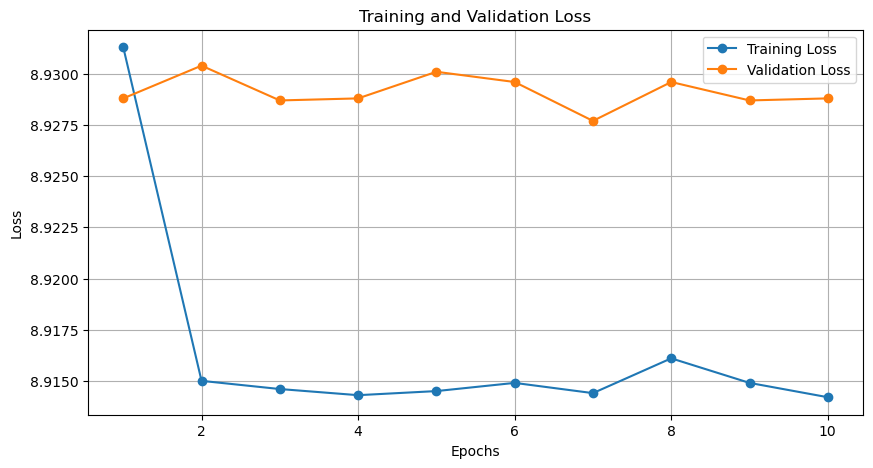

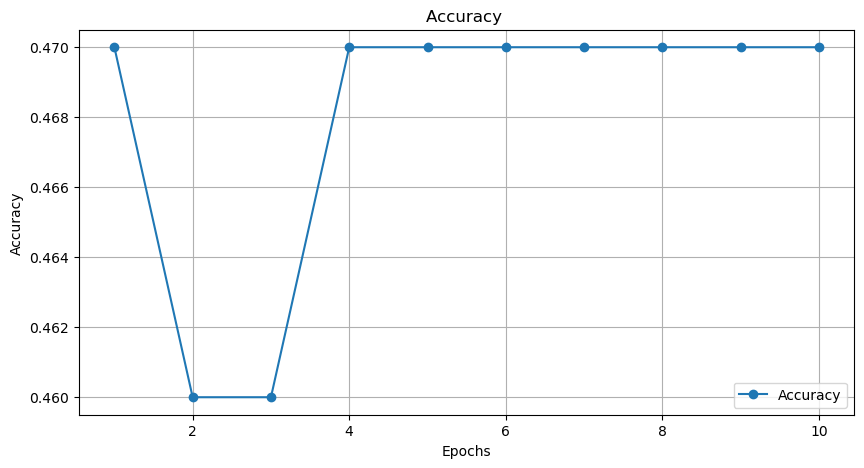

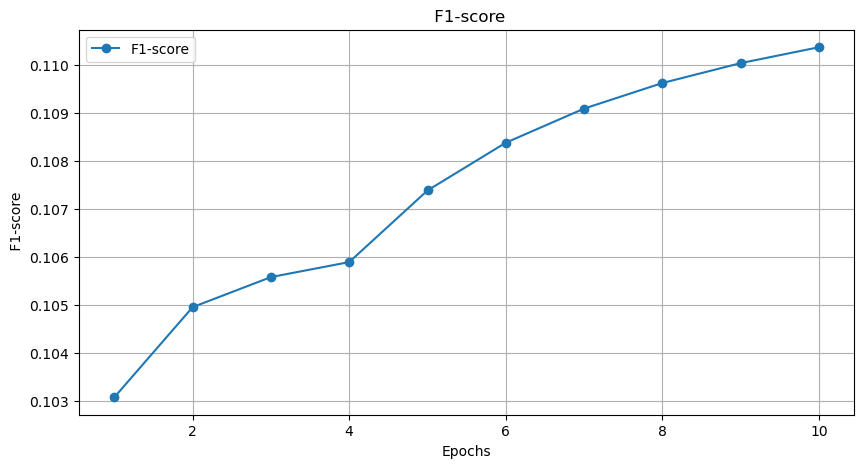

In [3]:
import matplotlib.pyplot as plt


epochs = range(1, len(training_loss) + 1)

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')

# Add labels and title for losses plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy and F1-score
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Accuracy', marker='o')


# Add labels and title for accuracy and F1-score plot
plt.xlabel('Epochs')
plt.ylabel('Accuracy' )
plt.title('Accuracy ')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_score, label='F1-score', marker='o')


# Add labels and title for accuracy and F1-score plot
plt.xlabel('Epochs')
plt.ylabel(' F1-score')
plt.title(' F1-score')

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model_save_path = "/Model2.pth"
                  #  /content/drive/MyDrive/NLP-Assign4
torch.save(model.state_dict(), model_save_path)

In [ ]:
# from sklearn.metrics import accuracy_score, f1_score
# import json
# import numpy as np

# # Load test data
# test_file = "/content/drive/MyDrive/NLP assignment 4/val_file.json"
# with open(test_file, 'r') as f:
#     test_data = json.load(f)

# # Create test dataset and dataloader (assuming you have a similar dataset and dataloader for the test data)
# test_dataset = EmotionTriggerDataset(test_file, max_length=512)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# # Put the model in evaluation mode
# model.eval()

# total_predictions = []
# total_labels = []

# for batch in tqdm(test_loader, desc="Evaluating on Test Data"):
#     inputs, last, labels = batch

#     # Move tensors to the same device
#     inputs = inputs.to(device)
#     last = last.to(device)
#     labels = labels.to(device)

#     # One-hot encode labels
#     labels_one_hot = F.one_hot(labels.long(), num_classes=3).float()

#     # Forward pass
#     with torch.no_grad():
#         outputs = model(inputs, last)

#     # Convert outputs and labels to numpy arrays
#     predicted_labels = (outputs >= 0.5).float().cpu().numpy()
#     true_labels = labels_one_hot.cpu().numpy()

#     total_predictions.extend(predicted_labels)
#     total_labels.extend(true_labels)

# # Compute accuracy
# total_predictions = np.array(total_predictions)
# total_labels = np.array(total_labels)
# accuracy = accuracy_score(total_labels.flatten(), total_predictions.flatten())
# f1 = f1_score(total_labels.flatten(), total_predictions.flatten(), average='weighted')

# print(f"Test Accuracy: {accuracy:.4f}")
# print(f"Test F1 Score: {f1:.4f}")
